<a href="https://colab.research.google.com/github/davidnussio/covid-19-ticino/blob/master/Covid_Ticino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title
!pip install -q lmfit

In [0]:
#@title
import pandas as pd
import matplotlib.pyplot as plt
import numpy 
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
from lmfit import Model, Parameters

In [0]:
# https://www.wikiwand.com/en/Generalised_logistic_function

# Model
def sigmoid(x, a, b, c):
  return a / (1 + numpy.exp(-b*(x-c)))

# Fst derivate
def sigmoid_dx(x, a, b, c):
  return (a * b * numpy.exp(-b*(x-c))) / ((numpy.exp(-b*(x-c)) + 1) ** 2)

In [46]:
#@title Configuration

num_sample = 34 #@param {type:"slider", min:20, max:34, step:1}

moving_avarage_win = 5 #@param {type:"integer"}

print('num_sample: ',num_sample)
print('moving_avarage_win: ', moving_avarage_win)

num_sample:  34
moving_avarage_win:  5


In [47]:
# Load data from github repo (github.com/davidnussio/covid-19-ticino)
csv_data = pd.read_csv("https://raw.githubusercontent.com/davidnussio/covid-19-ticino/master/data/covid-19-ticino.csv")
data = csv_data.fillna(method='ffill')

# Daily infected patients
new_infected = csv_data['ncumul_conf'].fillna(method='ffill').diff()
new_infected[0] = 1

# Number of data days
number_of_days = len(data['ncumul_conf'])

# Cumulative infected
yData = data['ncumul_conf']

# Days vector
xData = numpy.linspace(1, number_of_days, number_of_days)
xDataSample = numpy.linspace(1, num_sample, num_sample)

# Moving avarage
r = new_infected.rolling(moving_avarage_win, center=True, win_type='gaussian')
new_infected_rolling = r.mean(std=3)

#
yData_rolling = new_infected_rolling.cumsum().fillna(0)

#yData = yData_rolling

print('Number of days: ', number_of_days)
print('Date range: [', data['date'][0], '- ', data['date'][number_of_days - 1], ']')
# yData

Number of days:  34
Date range: [ 2020-02-25 -  2020-03-29 ]


In [48]:
#@title


# Model
smodel = Model(sigmoid)
fit_params = Parameters()
fit_params.add('a', value=500, min=200, max=10000)
fit_params.add('b', value=0.05, min=0, max=5)
fit_params.add('c', value=30, min=1, max=200)
#fit_params.add('d', value=1, min=0.95, max=1.15)

result = smodel.fit(yData[:num_sample], fit_params, x=xDataSample)

result

In [49]:
#@title
print('Number of day', number_of_days)

# Infected guess
infected_lower = int(round(result.params['a'].value - result.params['a'].stderr))
infected_upper = int(round(result.params['a'].value + result.params['a'].stderr))
print('Infected: ', infected_lower, ' - ', infected_upper)

# Peak day
peak_day_lower = int(round(result.params['c'].value - result.params['c'].stderr))
peak_day_upper = int(round(result.params['c'].value + result.params['c'].stderr))
print('Peak day: ', peak_day_lower, ' - ', peak_day_upper)

# Date
print('Peak date: ', data['date'][peak_day_lower], ' - ', data['date'][peak_day_upper])

Number of day 34
Infected:  2209  -  2421
Peak day:  28  -  29
Peak date:  2020-03-24  -  2020-03-25


- Number of day 31
- Infected:  1779  -  2064
- Peak day:  26  -  27
- Peak date:  2020-03-22  -  2020-03-23

---

- Number of day 32
- Infected:  2040  -  2345
- Peak day:  27  -  28
- Peak date:  2020-03-23  -  2020-03-24

---

- Number of day 34
- Infected:  2209  -  2421
- Peak day:  28  -  29
- Peak date:  2020-03-24  -  2020-03-25

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

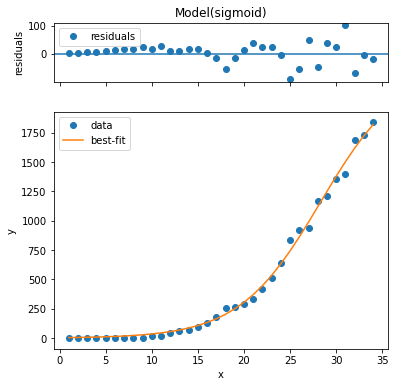

In [50]:
result.plot()

Tomorrow prediction:  35 1972.7741942318432
DELY:  34 34 34


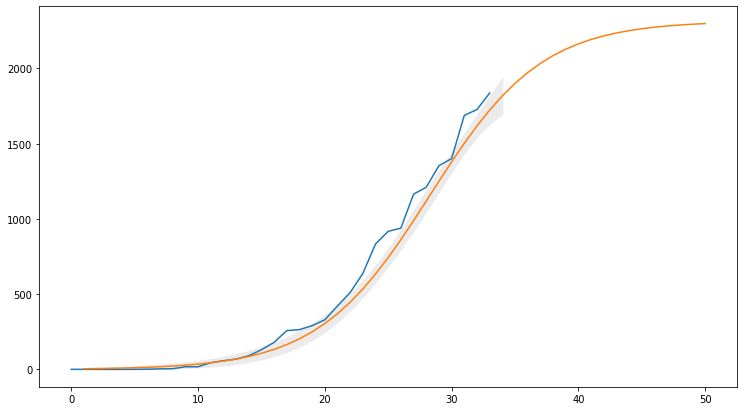

In [51]:
# Predicted n days
predicted_days = 50
x = numpy.linspace(1, predicted_days, predicted_days)

ySigmoid_dx = [sigmoid_dx(i, 
                          result.params['a'].value,
                          result.params['b'].value,
                          result.params['c'].value,
                          ) for i in x]

ySigmoid = smodel.eval(result.params, x=x)

ySigmoid2 = [sigmoid(i, 
                    result.params['a'].value - result.params['a'].stderr,
                    result.params['b'].value,
                    result.params['c'].value + result.params['c'].stderr,
                    ) for i in x]
ySigmoid3 = [sigmoid(i, 
                    result.params['a'].value + result.params['a'].stderr,
                    result.params['b'].value,
                    result.params['c'].value - result.params['c'].stderr,
                    ) for i in x]

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 7, forward=True)

ax.plot(data['ncumul_conf'])

# 
print('Tomorrow prediction: ', number_of_days + 1, ySigmoid[number_of_days + 1])

ax.plot(x, smodel.eval(params=result.params, x=x), label='Nelder', zorder=100)
dely = result.eval_uncertainty(sigma=4)
print('DELY: ', len(xData), len(dely), len(result.best_fit))
plt.fill_between(xDataSample, result.best_fit-dely, result.best_fit+dely, color="#EBEBEB")

plt.savefig('drive/My Drive/Colab Notebooks/Covid-Ticino/data-vs-model.png', dpi=100)

# Probability density function

**rolling average** (or moving average)

[jhsph study → 5.1 days](https://www.jhsph.edu/news/news-releases/2020/new-study-on-COVID-19-estimates-5-days-for-incubation-period.html)


<BarContainer object of 34 artists>

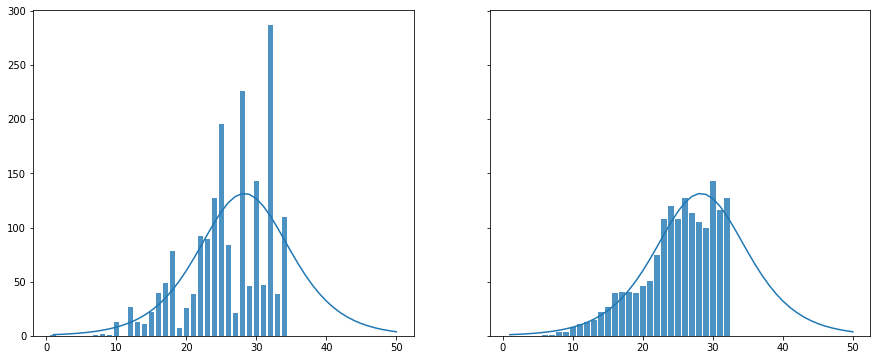

In [52]:
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all')

fig.set_size_inches(15, 6, forward=True)

xInf = numpy.linspace(1, len(new_infected), len(new_infected))

ax[0].plot(x, ySigmoid_dx)
ax[0].bar(xInf, new_infected, alpha=0.8)

ax[1].plot(x, ySigmoid_dx)
ax[1].bar(xInf, new_infected_rolling, alpha=0.8)


Tomorrow prediction: ↑  35 2095.040494156644
Tomorrow prediction: → 35 1972.7741942318432
Tomorrow prediction: ↓  35 1850.9706991192559


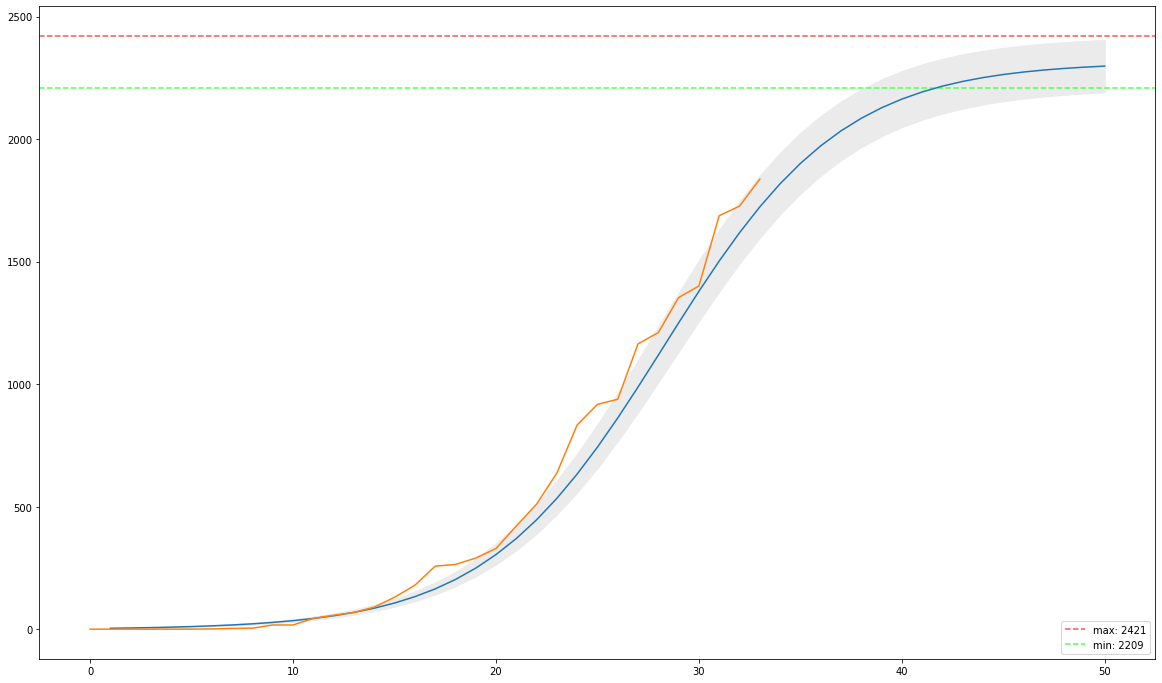

In [53]:
fig, ax = plt.subplots()

fig.set_size_inches(20, 12, forward=True)

ax.axhline(result.params['a'].value + result.params['a'].stderr, linestyle='dashed', color='#ff5555')
ax.axhline(result.params['a'].value - result.params['a'].stderr, linestyle='dashed', color='#55ff55')

ax.legend(("max: " + str(infected_upper), "min: " + str(infected_lower)))

ax.fill_between(x, ySigmoid2, ySigmoid3, color="#ebebeb")

ax.plot(x, ySigmoid)

ax.plot(data['ncumul_conf'])

print('Tomorrow prediction: ↑ ', number_of_days + 1, ySigmoid3[number_of_days + 1])
print('Tomorrow prediction: →', number_of_days + 1, ySigmoid[number_of_days + 1])
print('Tomorrow prediction: ↓ ', number_of_days + 1, ySigmoid2[number_of_days + 1])

